# SETI Breakthrough Listen challenge solution using a model ensemble

This notebook presents a solution to the Kaggle “SETI Breakthrough Listen - E.T. Signal Search” challenge:
- https://www.kaggle.com/competitions/seti-breakthrough-listen

The ensemble approach is based on the following backbone models that have been trained on the SETI dataset:
- ECA NFNet
- EfficientNet
- Regnet

## Install Python Packages

Install packagese required to run this notebook.

In [2]:
# Pretrained models
!pip install timm

# Image transformations

!pip install albumentations

# PyTorch configured to run on GPU (CUDA)
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

# Evaluation metrics, such as accuracy
!pip install torchsummary

# Momentum based gradient descent optimizer
!pip install AdamP

# API for logging evaluation metrics to the cloud
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Python Packages

Import packages used in this notebook.

In [3]:
# Python utility packages
import os
import random
from collections import defaultdict

# PyTorhc packages for building, running and evaluating models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Scikit learn utility packages
from sklearn.decomposition import NMF # non-negative matrix factorisation
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score # evaluation metrics

# OpenCV library used for image processing
import cv2

# Data and processing utility packages
import numpy as np
import pandas as pd

# Collection of pretrained models
import timm

# Batch processing helper
from tqdm import tqdm

# Image transformation helpers
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Utility for logging metrics using a cloud based API
import wandb

# Graph plotting library
from matplotlib import pyplot as plt

## Global Configuration

Create a configuration object for important values used in the notebook.

This makes them easy to track and tweak.

In [4]:
# Configuration object for important parameters used in the notebook
config = {
    'num_workers': 4,
    'model': 'nf_regnet_b5',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-8,
    'batch_size': 100,
    'epochs': 1,
    'num_folds': 2,
    'wandb_project': 'SETI - setigen dataset - 3',
    'wandb_run_name': 'ensemble'
}

## Random Seed Initialisation

Set random seeds to fixed values so the notebook results are reproducable.

In [5]:
'''
Sets seeds for randomness based functions.
'''
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



# Set the random seeds to a fixed value.
set_seeds(seed=config['seed'])

## Data Loading

Load the SETI dataset labels.

In [6]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\2000 dataset'
labels_filepath = os.path.join(data_dir, '2000_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)

initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [7]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   string
 1   target          2000 non-null   int32 
 2   image_filepath  2000 non-null   string
dtypes: int32(1), string(2)
memory usage: 39.2 KB


We can see that the data sample format include three fields:
- `id`: Containing the unique ID for the sample
- `target`: Indicates if the sample is positive (0) or negative (1)
- `image_filepath`: The location of the file containing the sample image data

Split the data with 70% for a training set and 30% for a test set:

In [8]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

## Image Processing Functions

Helper functions for processing the sample images.

In [9]:
'''
Resizes an image to the specified size.
'''
def resize_image(image):
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)



'''
Plots an image.
'''
def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()




'''
Min-max normalises the image pixel values (between 0 and 1).
'''
def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)



'''
Factorises an image into two matrices, and returns them.
Used to help remove image background noise.
'''
def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)



'''
Removes the background noise from a set of sample images.

Based on: https://www.kaggle.com/competitions/seti-breakthrough-listen/discussion/245950
'''
def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i] # Get on target image
        off_target_image = sample_images[i+1] # Get off target image

        on_W, on_H = get_decomposition_matrices(on_target_image) # Decompose on target images into factor matrices
        off_W, off_H = get_decomposition_matrices(off_target_image) # Decomponse off target images into factor matrices

        # Get noise approximation by multiplying a factor matrix from each of the on target, and off target images.
        # Then subtract the approximated noise from the on target images
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        # Consolidate the on target, off target and denoised images.
        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    # Return the denoised image
    return combined_denoised_image

## Custom Dataset

Create a custom dataset class.

This is used by the model to interact with a data sample.

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        images = np.load(images_filepath).astype(np.float32)
        image = get_denoised_image(images)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()

        label = torch.tensor(self.targets[idx]).float()

        return image, label

## Metric Monitoring

Create utility class and function to track loss, accuracy and AUC ROC metrics.

Used with the Weights and Biases web API.

In [11]:
'''
Class used by Weights and Biases web API for metric monitoring.
'''
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val'] / metric['count']

    def __str__(self):
        return " | ".join(
            [
                '{metric_name}: {avg:.{float_precision}f}'.format(
                    metric_name=metric_name, avg=metric['avg'],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )



'''
Helper method for returning the ROC AUC score for a prediction.
'''
def get_roc_auc(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5 # If an exception occurs, e.g. divide by zero, return a 0.5 score

## Model Classes

Create the classes for the models that will be used for classification.

In [12]:
'''
ECA NFNet model.
'''
class EcaNFNet(nn.Module):
    def __init__(self, model_name='eca_nfnet_l0', output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=input_channels)

        # Modify final layer to allow for a binary classification
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, output_features, bias=True)

    def forward(self, x):
        x = self.model(x)

        return x

In [13]:
'''
RegNet model.
'''
class RegNet(nn.Module):
    def __init__(self, model_name='nf_regnet_b1', output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=input_channels)

        # Modify final layer to allow for a binary classification
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, output_features, bias=True)

    def forward(self, x):
        x = self.model(x)

        return x

In [14]:
'''
EfficientNet model.
'''
class EfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b3', output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=input_channels)

        # Modify final layer to allow for a binary classification
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, output_features, bias=True)

    def forward(self, x):
        x = self.model(x)

        return x

## Loss Criterion

Define a loss criterion function for measuring loss:

In [15]:
criterion = nn.BCEWithLogitsLoss().to(config['device'])

## Data Loader

Data loader used during classification to access the data.

In [16]:
'''
Data loader for the test data.
'''

def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return test_loader

## Test Function

The function used to classify a model against the test dataset.

In [17]:
'''
Function for testing a model against the test dataset.

It receives a model and model state to restore as input.
It returns the model predictions for the ground truth labels.
'''
def test_model(model, model_state_file):
    # keep track of the predictions and ground truth labels
    final_targets = []
    final_outputs = []

    # initialise the model and place it in evaluation mode
    model_state = torch.load(os.path.join('ensemble models', '22-09-10', model_state_file))
    model.load_state_dict(model_state)
    model.eval()

    # initialise the metric monitor for reporting progress
    metric_monitor = MetricMonitor()

    # initialise the test data loader with the test data
    test_loader = get_test_loader(test_df)

    # create the stream for iterating through the test data batch
    stream = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad(): # don't perform any back propogation as we only want to evaluate
        for i, (images, target) in stream: # iterate through each test data batch
            images = images.to('cpu', non_blocking=True)
            target = target.to('cpu', non_blocking=True).float().view(-1, 1)

            # make predictions
            output = model(images)

            # calculate metric performance metrics
            loss = criterion(output, target)
            accuracy = accuracy_score(target.cpu(), (output.cpu().detach().numpy() > 0), normalize=False)
            roc_auc = get_roc_auc(output, target)

            # report the metrics to the monitor for displaying model progress
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC AUC', roc_auc)

            # report the metrics the W&B web API
            wandb.log({'Test Loss': loss.item(), 'Test Accuracy': accuracy, 'Test ROC AUC': roc_auc})

            # print the current model progress
            stream.set_description('Test {metric_monitor}'.format(metric_monitor=metric_monitor))

            # get the ground truth labels and predictions, so they can be returned
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(outputs)

    # return predictions and ground truth labels
    return final_outputs, final_targets

## Weights and Biases Initialisation

Initialise W&B with the project and run name to log metrics to.

In [18]:
wandb.init(
    project=config['wandb_project'],
    config=config,
    job_type='test',
    name=config['wandb_run_name']
)

wandb: Currently logged in as: mllm3. Use `wandb login --relogin` to force relogin


## Model Predictions

Instantiate models with states saved from when they were previously trained on the SETI dataset.

Then get their predictions against the test set:

In [19]:
# initialise models to test
ecanfnet_model = EcaNFNet()
regnet_model = RegNet()
efficientnet_model = EfficientNet()


# get model predictions against test data
ecanfnet_outputs, ecanfnet_targets = test_model(ecanfnet_model, 'eca_nfnet_l0_fold_2_epoch_1_roc_auc_1.0.pth')
regnet_outputs, regnet_targets = test_model(regnet_model, 'nf_regnet_b1_fold_2_epoch_1_roc_auc_1.0.pth')
efficientnet_outputs, efficientnet_targets = test_model(efficientnet_model, 'tf_efficientnet_b3_fold_1_epoch_2_roc_auc_1.0.pth')

Test Loss: 1.091 | ROC AUC: 0.498: 100%|██████████| 6/6 [03:02<00:00, 30.42s/it]
Test Loss: 1.225 | ROC AUC: 0.500: 100%|██████████| 6/6 [01:10<00:00, 11.72s/it]
Test Loss: 56.308 | ROC AUC: 0.498: 100%|██████████| 6/6 [02:27<00:00, 24.51s/it] 


## Model Ensemble

Two different methods are used to calculate an ensemble prediction:

### Sum of raw predictions method

Min-max normalise and sum the individual model predictions to get the ensemble prediction:

In [20]:
'''
Returns min-max normalised predictions (between 0 and 1).
'''
def get_normalised_predictions(predictions):
    predictions_min = min(predictions)[0]
    predictions_max = max(predictions)[0]

    # if all predictions are the same, return list of 0's
    if predictions_min == predictions_max:
        return [0] * len(predictions)

    return [(x[0] - predictions_min) / (predictions_max - predictions_min) for x in predictions]

In [21]:
ecanfnet_norm_predictions = get_normalised_predictions(ecanfnet_outputs)
regnet_norm_predictions = get_normalised_predictions(regnet_outputs)
efficientnet_norm_predictions = get_normalised_predictions(efficientnet_outputs)

In [22]:
ensemble_predictions = np.array(ecanfnet_norm_predictions) + np.array(regnet_norm_predictions) + np.array(efficientnet_norm_predictions)

Plot ROC curve with label for ROC AUC:

In [23]:
'''
Plot ROC curve, with a label for ROC AUC.
'''
def plot_roc_curve(targets, predictions):
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = roc_auc_score(targets, predictions)

    plt.plot(fpr,tpr)

    plt.plot(fpr, tpr, label="ROC AUC = " + str(roc_auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

    plt.show()

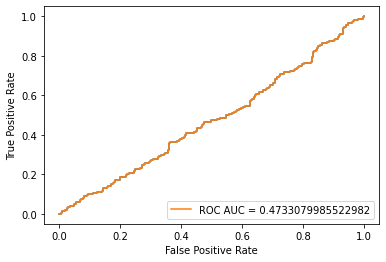

In [24]:
plot_roc_curve(ecanfnet_targets, ensemble_predictions)

Get optimal classification threshold:

In [25]:
'''
Returns threshold from ROC curve that gives highest
True Positive Rate vs. False Positive Rate.
'''
def get_optimal_threshold(targets, predictions):
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])[0]

In [26]:
optimal_threshold = get_optimal_threshold(ecanfnet_targets, ensemble_predictions)
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 1.5483484108887244


Use optimal threshold to make binary classifications:

In [29]:
'''
Returns a dataframe composed of ground truth labels and binary classifications.
'''
def get_predictions_dataframe(targets, predictions, threshold):
    results_df = pd.DataFrame([targets, predictions])
    results_df = results_df.transpose()
    results_df.columns = ['label', 'prediction']

    results_df['label'] = results_df['label'].apply(lambda x: x[0])
    results_df['prediction'] = results_df['prediction'].apply(lambda x: x)

    # Use threshold of > 0.5 for a positive prediction, else it is a negative prediction
    results_df['prediction'] = results_df['prediction'].apply(lambda x: 0.0 if x < threshold else 1.0)

    return results_df

In [30]:
sum_ensemble_results_df = get_predictions_dataframe(ecanfnet_targets, ensemble_predictions, optimal_threshold)

Gather ensemble metrics:

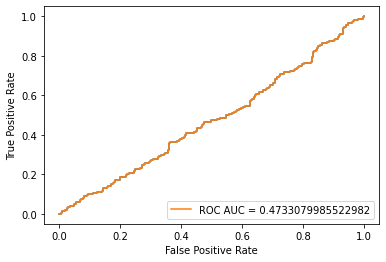

In [32]:
plot_roc_curve(ecanfnet_targets, ensemble_predictions)

In [33]:
pd.crosstab(sum_ensemble_results_df['prediction'], sum_ensemble_results_df['label'])

label,0.0,1.0
prediction,,
0.0,139,159
1.0,149,148


In [34]:
print(classification_report(sum_ensemble_results_df['prediction'], sum_ensemble_results_df['label']))

              precision    recall  f1-score   support

         0.0       0.48      0.47      0.47       298
         1.0       0.48      0.50      0.49       297

    accuracy                           0.48       595
   macro avg       0.48      0.48      0.48       595
weighted avg       0.48      0.48      0.48       595



### Modal prediction method

This ensemble method uses the modal binary classification to calculate the ensemble one.

First calculate binary classifications using the optimal classification threshold for each model:

In [35]:
ecanfnet_optimal_threshold = get_optimal_threshold(ecanfnet_targets, ecanfnet_outputs)
print('Optimal ECANFNet threshold:', ecanfnet_optimal_threshold)

regnet_optimal_threshold = get_optimal_threshold(regnet_targets, regnet_outputs)
print('Optimal RegNet threshold:', regnet_optimal_threshold)

efficientnet_optimal_threshold = get_optimal_threshold(efficientnet_targets, efficientnet_outputs)
print('Optimal EfficientNet threshold:', efficientnet_optimal_threshold)

Optimal ECANFNet threshold: 1.1789767742156982
Optimal RegNet threshold: 1.9824620485305786
Optimal EfficientNet threshold: -0.18559516966342926


In [36]:
'''
Returns a dataframe composed of ground truth labels and binary classifications.
'''
def get_predictions_dataframe(targets, predictions, threshold):
    results_df = pd.DataFrame([targets, predictions])
    results_df = results_df.transpose()
    results_df.columns = ['label', 'prediction']

    results_df['label'] = results_df['label'].apply(lambda x: x[0])
    results_df['prediction'] = results_df['prediction'].apply(lambda x: x[0])

    # Use threshold of > 0.5 for a positive prediction, else it is a negative prediction
    results_df['prediction'] = results_df['prediction'].apply(lambda x: 0.0 if x < threshold else 1.0)

    return results_df



# get predictions for each model
ecanfnet_results_df = get_predictions_dataframe(ecanfnet_targets, ecanfnet_outputs, ecanfnet_optimal_threshold)
regnet_results_df = get_predictions_dataframe(regnet_targets, regnet_outputs, regnet_optimal_threshold)
efficientnet_results_df = get_predictions_dataframe(efficientnet_targets, efficientnet_outputs, efficientnet_optimal_threshold)

Calculate the modal prediction for all three models:

In [37]:
'''
Given three predictions, returns their mode value.
'''
def get_mode_prediction(prediction_1, prediction_2, prediction_3):
    predictions = pd.Series([prediction_1, prediction_2, prediction_3])

    return predictions.mode()

In [38]:
# build dataframe with mode prediction results
model_ensemble_results_df = pd.DataFrame()

model_ensemble_results_df['label'] = efficientnet_results_df['label']

model_ensemble_results_df['ecanfnet_prediction'] = efficientnet_results_df['prediction']
model_ensemble_results_df['regnet_prediction'] = regnet_results_df['prediction']
model_ensemble_results_df['efficientnet_prediction'] = efficientnet_results_df['prediction']

# get the mode prediction for each row for the ensemble prediction
model_ensemble_results_df['ensemble_prediction'] = model_ensemble_results_df.apply(
    lambda row: get_mode_prediction(row['ecanfnet_prediction'], row['regnet_prediction'], row['efficientnet_prediction']),
    axis=1
)

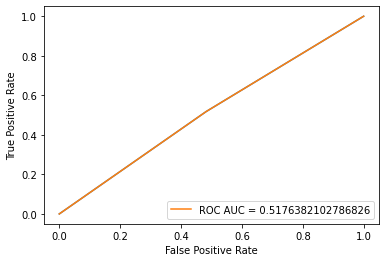

In [39]:
plot_roc_curve(model_ensemble_results_df['label'], model_ensemble_results_df['ensemble_prediction'])

### Print metrics for the model ensemble predictions:

In [40]:
pd.crosstab(model_ensemble_results_df['ensemble_prediction'], model_ensemble_results_df['label'])

label,0.0,1.0
ensemble_prediction,,
0.0,149,148
1.0,139,159


In [41]:
print(classification_report(model_ensemble_results_df['ensemble_prediction'], model_ensemble_results_df['label']))

              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       297
         1.0       0.52      0.53      0.53       298

    accuracy                           0.52       595
   macro avg       0.52      0.52      0.52       595
weighted avg       0.52      0.52      0.52       595

